Epoch 1/100, Loss: 0.6670, Train Acc: 0.8586, Val Acc: 0.8231
Epoch 2/100, Loss: 0.2878, Train Acc: 0.8790, Val Acc: 0.8027
Epoch 3/100, Loss: 0.3889, Train Acc: 0.8944, Val Acc: 0.8299
Epoch 4/100, Loss: 0.2252, Train Acc: 0.8961, Val Acc: 0.8367
Epoch 5/100, Loss: 0.3970, Train Acc: 0.9046, Val Acc: 0.8231
Epoch 6/100, Loss: 0.7042, Train Acc: 0.9063, Val Acc: 0.8163
Epoch 7/100, Loss: 1.0826, Train Acc: 0.9063, Val Acc: 0.8367
Epoch 8/100, Loss: 0.5330, Train Acc: 0.9097, Val Acc: 0.8367
Epoch 9/100, Loss: 0.2812, Train Acc: 0.9131, Val Acc: 0.8231
Epoch 10/100, Loss: 0.3452, Train Acc: 0.9250, Val Acc: 0.8435
Epoch 11/100, Loss: 0.4080, Train Acc: 0.9131, Val Acc: 0.8639
Epoch 12/100, Loss: 0.1372, Train Acc: 0.9250, Val Acc: 0.8435
Epoch 13/100, Loss: 0.2352, Train Acc: 0.9165, Val Acc: 0.8367
Epoch 14/100, Loss: 0.4615, Train Acc: 0.9182, Val Acc: 0.8503
Epoch 15/100, Loss: 0.1669, Train Acc: 0.9182, Val Acc: 0.8435
Epoch 16/100, Loss: 0.2640, Train Acc: 0.9250, Val Acc: 0.8503
E

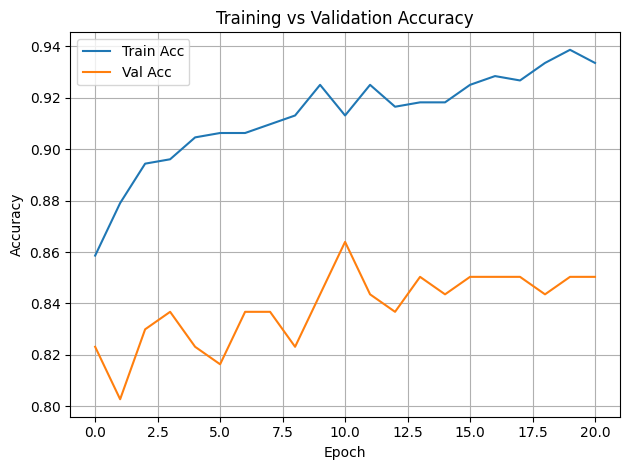

📁 Saved sensor features to 'sensor_features.npy'
📁 Saved sensor labels to 'sensor_labels.npy'
💾 Model saved to 'heart_model.pkl'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv("heart.csv")
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"].values

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(drop='first'), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

# Stratified split: train (64%), val (16%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# Define enhanced ANN model
class HeartModel(nn.Module):
    # Corrected the constructor method name from _init_ to __init__
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)  # No Sigmoid here
        )

    def forward(self, x):
        return self.net(x)

model = HeartModel(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Training loop with early stopping
best_val_acc = 0
epochs_no_improve = 0
patience = 10
num_epochs = 100
train_accuracies, val_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_preds = torch.sigmoid(model(X_train))
        val_preds = torch.sigmoid(model(X_val))

        train_acc = accuracy_score(y_train, train_preds > 0.5)
        val_acc = accuracy_score(y_val, val_preds > 0.5)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_state)

# Test evaluation
model.eval()
with torch.no_grad():
    test_preds = torch.sigmoid(model(X_test)).numpy().flatten()
    y_pred = (test_preds > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot accuracy
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# === Save preprocessed features and labels ===
np.save('sensor_features2.npy', X_processed)
np.save('sensor_labels2.npy', y)
print("📁 Saved sensor features to 'sensor_features.npy'")
print("📁 Saved sensor labels to 'sensor_labels.npy'")

# === Save the trained model ===
import pickle

with open('heart_model2.pkl', 'wb') as f:
    pickle.dump({
        'model_state_dict': best_model_state,
        'input_dim': X_train.shape[1]
    }, f)

print("💾 Model saved to 'heart_model.pkl'")

In [4]:
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings

# Optional: suppress XGBoost label encoder warning
warnings.filterwarnings('ignore', category=UserWarning)

# 🧪 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 🔧 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load data
sensor_X = np.load("sensor_features2.npy")
sensor_y = np.load("sensor_labels2.npy")
mri_X = np.load("mri_features.npy")

# ✂️ Truncate to equal length
min_samples = min(sensor_X.shape[0], mri_X.shape[0])
sensor_X = sensor_X[:min_samples]
sensor_y = sensor_y[:min_samples]
mri_X = mri_X[:min_samples]

# 🔄 Standardize features
sensor_scaler = StandardScaler().fit(sensor_X)
mri_scaler = StandardScaler().fit(mri_X)
sensor_X_scaled = sensor_scaler.transform(sensor_X)
mri_X_scaled = mri_scaler.transform(mri_X)

# 🎯 Apply PCA
sensor_pca = PCA(n_components=14).fit(sensor_X_scaled)
mri_pca = PCA(n_components=43).fit(mri_X_scaled)
sensor_features = sensor_pca.transform(sensor_X_scaled)
mri_features = mri_pca.transform(mri_X_scaled)

# 🔗 Mid-level fusion
fused_X = np.concatenate([sensor_features, mri_features], axis=1)

# 🧪 Stratified Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in sss.split(fused_X, sensor_y):
    X_train, X_test = fused_X[train_idx], fused_X[test_idx]
    y_train, y_test = sensor_y[train_idx], sensor_y[test_idx]

# 🧠 Define DNN model
class EnsembleDNN(nn.Module):
    def __init__(self, input_dim):
        super(EnsembleDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🎯 Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# 🎯 Prepare tensors for DNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 🎯 Train DNN
dnn_model = EnsembleDNN(fused_X.shape[1]).to(device)
optimizer = torch.optim.AdamW(dnn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dnn_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    output = dnn_model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# 🎯 Predict with DNN
dnn_model.eval()
with torch.no_grad():
    dnn_output = dnn_model(X_test_tensor)
    dnn_preds = torch.sigmoid(dnn_output).cpu().numpy()

# 🧪 Ensemble (average DNN + XGBoost predictions)
ensemble_preds = (dnn_preds + xgb_preds.reshape(-1, 1)) / 2

# 📈 Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds > 0.5))
print(classification_report(y_test, ensemble_preds > 0.5))


Ensemble Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        82
           1       0.91      0.93      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184



In [5]:
import joblib
import pickle 
with open("sensor_scaler2.pkl", "wb") as f:
    pickle.dump(sensor_scaler, f)
with open("mri_scaler.pkl", "wb") as f:
    pickle.dump(mri_scaler, f)
with open("sensor_pca2.pkl", "wb") as f:
    pickle.dump(sensor_pca, f)
with open("mri_pca.pkl", "wb") as f:
    pickle.dump(mri_pca, f)
joblib.dump(xgb_model, "xgb_model.pkl")

# Save DNN model state_dict (use torch)
torch.save(dnn_model.state_dict(), "dnn_model_state_dict.pth")

print("Models saved successfully!")


print("💾 All models and scalers saved successfully!")

Models saved successfully!
💾 All models and scalers saved successfully!


array([[ 3.14023620e+00,  4.23502789e-01,  6.45638410e-01, ...,
        -4.47808078e-02,  2.97832451e-01,  7.50793426e-02],
       [ 2.32365593e-01,  1.09015917e+00,  7.78345535e-01, ...,
        -2.51376039e-01, -6.55945519e-02,  2.04621573e-01],
       [ 1.65293842e+00, -2.15351134e+00,  3.04967933e-01, ...,
        -1.96561220e+00,  4.80221025e-01, -6.54580310e-01],
       ...,
       [-1.74810152e+00,  1.48845990e+00, -3.37442741e-01, ...,
         4.24764247e-01,  6.74167021e-02,  1.51886902e-01],
       [ 1.10315428e+00, -2.07486802e-01,  1.75726110e+00, ...,
         1.38395573e+00,  7.01096706e-02, -6.61504825e-01],
       [ 2.52724324e+00,  4.78742924e-01, -9.52918619e-01, ...,
        -5.83864661e-02,  1.39774368e-03,  1.11951710e-01]],
      shape=(918, 14))

In [20]:
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings
import pickle
import joblib
# Optional: suppress XGBoost label encoder warning
warnings.filterwarnings('ignore', category=UserWarning)

# 🧪 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 🔧 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load data
sensor_X = np.load("sensor_features2.npy")
sensor_y = np.load("sensor_labels2.npy")
mri_X = np.load("mri_features.npy")

# ✂️ Truncate to equal length
min_samples = min(sensor_X.shape[0], mri_X.shape[0])
sensor_X = sensor_X[:min_samples]
sensor_y = sensor_y[:min_samples]
mri_X = mri_X[:min_samples]

from sklearn.preprocessing import StandardScaler

# Standardize raw features first (already there)
sensor_scaler = StandardScaler().fit(sensor_X)
mri_scaler = StandardScaler().fit(mri_X)
sensor_X_scaled = sensor_scaler.transform(sensor_X)
mri_X_scaled = mri_scaler.transform(mri_X)

# Apply PCA
sensor_pca = PCA(n_components=14).fit(sensor_X_scaled)
mri_pca = PCA(n_components=43).fit(mri_X_scaled)
sensor_features = sensor_pca.transform(sensor_X_scaled)  # shape (n_samples, 14)
mri_features = mri_pca.transform(mri_X_scaled)          # shape (n_samples, 43)

# --- NEW STEP ---
# Scale PCA sensor features to zero mean, unit variance
sensor_pca_scaler = StandardScaler().fit(sensor_features)
sensor_features_scaled = sensor_pca_scaler.transform(sensor_features)


with open('sensor_scaler.pkl', 'wb') as f:
    pickle.dump(sensor_scaler, f)
with open('mri_scaler.pkl', 'wb') as f:
    pickle.dump(mri_scaler, f)
with open('sensor_pca.pkl', 'wb') as f:
    pickle.dump(sensor_pca, f)
with open('mri_pca.pkl', 'wb') as f:
    pickle.dump(mri_pca, f)
with open('sensor_pca_scaler.pkl', 'wb') as f:
    pickle.dump(sensor_pca_scaler, f)
# Concatenate scaled sensor PCA features with MRI PCA features
fused_X = np.concatenate([sensor_features_scaled, mri_features], axis=1)
fused_X_fit = StandardScaler().fit(fused_X)
with open('concatenated_scaler.pkl', 'wb') as f :
    pickle.dump(fused_X_fit, f)



# 🧪 Stratified Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in sss.split(fused_X, sensor_y):
    X_train, X_test = fused_X[train_idx], fused_X[test_idx]
    y_train, y_test = sensor_y[train_idx], sensor_y[test_idx]

# 🧠 Define DNN model
class EnsembleDNN(nn.Module):
    def __init__(self, input_dim):
        super(EnsembleDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🎯 Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# 🎯 Prepare tensors for DNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 🎯 Train DNN
dnn_model = EnsembleDNN(fused_X.shape[1]).to(device)
optimizer = torch.optim.AdamW(dnn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dnn_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    output = dnn_model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# 🎯 Predict with DNN
dnn_model.eval()
with torch.no_grad():
    dnn_output = dnn_model(X_test_tensor)
    dnn_preds = torch.sigmoid(dnn_output).cpu().numpy()

# 🧪 Ensemble (average DNN + XGBoost predictions)
ensemble_preds = (dnn_preds + xgb_preds.reshape(-1, 1)) / 2

# 📈 Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds > 0.5))
print(classification_report(y_test, ensemble_preds > 0.5))
joblib.dump(xgb_model, "xgb_model.pkl")

# Save DNN model state_dict (use torch)
torch.save(dnn_model.state_dict(), "dnn_model_state_dict.pth")


Ensemble Accuracy: 0.8967391304347826
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [15]:
# After you fit and transform sensor features with PCA and scaler during training
sensor_pca_features_scaled = sensor_pca_scaler.transform(sensor_features)  # This is your "post_pca_scaler"

print("Training sensor PCA feature stats:")
print("Max:", np.max(sensor_pca_features_scaled))
print("Min:", np.min(sensor_pca_features_scaled))
print("Mean:", np.mean(sensor_pca_features_scaled))
print("Std:", np.std(sensor_pca_features_scaled))


Training sensor PCA feature stats:
Max: 4.7433506884834635
Min: -3.922389568501453
Mean: -3.538339175898414e-17
Std: 0.9999999999999998


# APPLYING LABEL ENCOINF INSTEAD OF THE ONE HOT ENCODING 

Epoch 1/100, Loss: 0.4796, Train Acc: 0.8450, Val Acc: 0.7619
Epoch 2/100, Loss: 0.6931, Train Acc: 0.8620, Val Acc: 0.8027
Epoch 3/100, Loss: 0.6340, Train Acc: 0.8586, Val Acc: 0.8095
Epoch 4/100, Loss: 0.3377, Train Acc: 0.8705, Val Acc: 0.8027
Epoch 5/100, Loss: 0.5026, Train Acc: 0.8807, Val Acc: 0.8163
Epoch 6/100, Loss: 0.3066, Train Acc: 0.8739, Val Acc: 0.8503
Epoch 7/100, Loss: 0.3242, Train Acc: 0.8739, Val Acc: 0.8299
Epoch 8/100, Loss: 0.2908, Train Acc: 0.8876, Val Acc: 0.8367
Epoch 9/100, Loss: 0.2311, Train Acc: 0.8876, Val Acc: 0.8299
Epoch 10/100, Loss: 0.5754, Train Acc: 0.8842, Val Acc: 0.8367
Epoch 11/100, Loss: 0.2805, Train Acc: 0.8927, Val Acc: 0.8299
Epoch 12/100, Loss: 0.7257, Train Acc: 0.8927, Val Acc: 0.8435
Epoch 13/100, Loss: 0.7380, Train Acc: 0.8893, Val Acc: 0.8435
Epoch 14/100, Loss: 0.3252, Train Acc: 0.8927, Val Acc: 0.8367
Epoch 15/100, Loss: 0.1502, Train Acc: 0.8978, Val Acc: 0.8571
Epoch 16/100, Loss: 0.4140, Train Acc: 0.8944, Val Acc: 0.8367
E

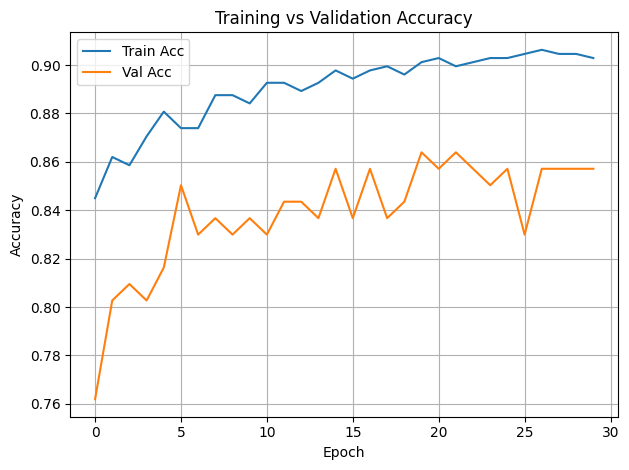

📁 Saved sensor features to 'sensor_features.npy'
📁 Saved sensor labels to 'sensor_labels.npy'
💾 Model saved to 'heart_model.pkl'


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Load and preprocess dataset
df = pd.read_csv("heart (3).csv")
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"].values

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Apply Label Encoding to categorical columns
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le  # Save if you want to inverse transform later

# Standard scaling only for numerical columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X_processed = X.values  # Now all numeric and scaled

# Stratified split: train (64%), val (16%), test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# Define enhanced ANN model
class HeartModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),

            nn.Linear(32, 1)  # No Sigmoid here
        )

    def forward(self, x):
        return self.net(x)

model = HeartModel(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Training loop with early stopping
best_val_acc = 0
epochs_no_improve = 0
patience = 10
num_epochs = 100
train_accuracies, val_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_preds = torch.sigmoid(model(X_train))
        val_preds = torch.sigmoid(model(X_val))

        train_acc = accuracy_score(y_train, train_preds > 0.5)
        val_acc = accuracy_score(y_val, val_preds > 0.5)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(best_model_state)

# Test evaluation
model.eval()
with torch.no_grad():
    test_preds = torch.sigmoid(model(X_test)).numpy().flatten()
    y_pred = (test_preds > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot accuracy
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Save preprocessed features and labels ===
np.save('sensor_features2.npy', X_processed)
np.save('sensor_labels2.npy', y)
print("📁 Saved sensor features to 'sensor_features.npy'")
print("📁 Saved sensor labels to 'sensor_labels.npy'")

# === Save the trained model ===
import pickle

with open('heart_model2.pkl', 'wb') as f:
    pickle.dump({
        'model_state_dict': best_model_state,
        'input_dim': X_train.shape[1]
    }, f)

print("💾 Model saved to 'heart_model.pkl'")


In [30]:
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings

# Optional: suppress XGBoost label encoder warning
warnings.filterwarnings('ignore', category=UserWarning)

# 🧪 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 🔧 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load data
sensor_X = np.load("sensor_features2.npy")
sensor_y = np.load("sensor_labels2.npy")
mri_X = np.load("mri_features.npy")

# ✂️ Truncate to equal length
min_samples = min(sensor_X.shape[0], mri_X.shape[0])
sensor_X = sensor_X[:min_samples]
sensor_y = sensor_y[:min_samples]
mri_X = mri_X[:min_samples]

# 🔄 Standardize features
sensor_scaler = StandardScaler().fit(sensor_X)
mri_scaler = StandardScaler().fit(mri_X)
sensor_X_scaled = sensor_scaler.transform(sensor_X)
mri_X_scaled = mri_scaler.transform(mri_X)

# 🎯 Apply PCA
sensor_pca = PCA(n_components=11).fit(sensor_X_scaled)
mri_pca = PCA(n_components=43).fit(mri_X_scaled)
sensor_features = sensor_pca.transform(sensor_X_scaled)
mri_features = mri_pca.transform(mri_X_scaled)

# 🔗 Mid-level fusion
fused_X = np.concatenate([sensor_features, mri_features], axis=1)

# 🧪 Stratified Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in sss.split(fused_X, sensor_y):
    X_train, X_test = fused_X[train_idx], fused_X[test_idx]
    y_train, y_test = sensor_y[train_idx], sensor_y[test_idx]

# 🧠 Define DNN model
class EnsembleDNN(nn.Module):
    def __init__(self, input_dim):
        super(EnsembleDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🎯 Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# 🎯 Prepare tensors for DNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 🎯 Train DNN
dnn_model = EnsembleDNN(fused_X.shape[1]).to(device)
optimizer = torch.optim.AdamW(dnn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dnn_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    output = dnn_model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# 🎯 Predict with DNN
dnn_model.eval()
with torch.no_grad():
    dnn_output = dnn_model(X_test_tensor)
    dnn_preds = torch.sigmoid(dnn_output).cpu().numpy()

# 🧪 Ensemble (average DNN + XGBoost predictions)
ensemble_preds = (dnn_preds + xgb_preds.reshape(-1, 1)) / 2

# 📈 Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds > 0.5))
print(classification_report(y_test, ensemble_preds > 0.5))


Ensemble Accuracy: 0.8641304347826086
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        82
           1       0.85      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings

# Optional: suppress XGBoost label encoder warning
warnings.filterwarnings('ignore', category=UserWarning)

# 🧪 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 🔧 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load data
sensor_X = np.load("sensor_features2.npy")
sensor_y = np.load("sensor_labels2.npy")
mri_X = np.load("mri_features.npy")

# ✂️ Truncate to equal length
min_samples = min(sensor_X.shape[0], mri_X.shape[0])
sensor_X = sensor_X[:min_samples]
sensor_y = sensor_y[:min_samples]
mri_X = mri_X[:min_samples]

# 🔄 Standardize features
sensor_scaler = StandardScaler().fit(sensor_X)
mri_scaler = StandardScaler().fit(mri_X)
sensor_X_scaled = sensor_scaler.transform(sensor_X)
mri_X_scaled = mri_scaler.transform(mri_X)

# 🎯 Apply PCA
sensor_pca = PCA(n_components=11).fit(sensor_X_scaled)
mri_pca = PCA(n_components=43).fit(mri_X_scaled)
sensor_features = sensor_pca.transform(sensor_X_scaled)
mri_features = mri_pca.transform(mri_X_scaled)

# 🔗 Mid-level fusion
fused_X = np.concatenate([sensor_features, mri_features], axis=1)

# 🧪 Stratified Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in sss.split(fused_X, sensor_y):
    X_train, X_test = fused_X[train_idx], fused_X[test_idx]
    y_train, y_test = sensor_y[train_idx], sensor_y[test_idx]

# 🧠 Define DNN model
class EnsembleDNN(nn.Module):
    def __init__(self, input_dim):
        super(EnsembleDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🎯 Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# 🎯 Prepare tensors for DNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 🎯 Train DNN
dnn_model = EnsembleDNN(fused_X.shape[1]).to(device)
optimizer = torch.optim.AdamW(dnn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dnn_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    output = dnn_model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# 🎯 Predict with DNN
dnn_model.eval()
with torch.no_grad():
    dnn_output = dnn_model(X_test_tensor)
    dnn_preds = torch.sigmoid(dnn_output).cpu().numpy()

# 🧪 Ensemble (average DNN + XGBoost predictions)
ensemble_preds = (dnn_preds + xgb_preds.reshape(-1, 1)) / 2

# 📈 Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds > 0.5))
print(classification_report(y_test, ensemble_preds > 0.5))


In [1]:
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import warnings

# Optional: suppress XGBoost label encoder warning
warnings.filterwarnings('ignore', category=UserWarning)

# 🧪 Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 🔧 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📥 Load data
sensor_X = np.load("sensor_features2.npy")
sensor_y = np.load("sensor_labels2.npy")
mri_X = np.load("mri_features.npy")

# ✂️ Truncate to equal length
min_samples = min(sensor_X.shape[0], mri_X.shape[0])
sensor_X = sensor_X[:min_samples]
sensor_y = sensor_y[:min_samples]
mri_X = mri_X[:min_samples]

# 🔄 Standardize features
sensor_scaler = StandardScaler().fit(sensor_X)
mri_scaler = StandardScaler().fit(mri_X)
sensor_X_scaled = sensor_scaler.transform(sensor_X)
mri_X_scaled = mri_scaler.transform(mri_X)

# 🎯 Apply PCA
sensor_pca = PCA(n_components=11).fit(sensor_X_scaled)
mri_pca = PCA(n_components=43).fit(mri_X_scaled)
sensor_features = sensor_pca.transform(sensor_X_scaled)
mri_features = mri_pca.transform(mri_X_scaled)

# 🔗 Mid-level fusion
fused_X = np.concatenate([sensor_features, mri_features], axis=1)

# 🧪 Stratified Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, test_idx in sss.split(fused_X, sensor_y):
    X_train, X_test = fused_X[train_idx], fused_X[test_idx]
    y_train, y_test = sensor_y[train_idx], sensor_y[test_idx]

# 🧠 Define DNN model
class EnsembleDNN(nn.Module):
    def __init__(self, input_dim):
        super(EnsembleDNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# 🎯 Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_test)[:, 1]

# 🎯 Prepare tensors for DNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# 🎯 Train DNN
dnn_model = EnsembleDNN(fused_X.shape[1]).to(device)
optimizer = torch.optim.AdamW(dnn_model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()

dnn_model.train()
for epoch in range(20):
    optimizer.zero_grad()
    output = dnn_model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()

# 🎯 Predict with DNN
dnn_model.eval()
with torch.no_grad():
    dnn_output = dnn_model(X_test_tensor)
    dnn_preds = torch.sigmoid(dnn_output).cpu().numpy()

# 🧪 Ensemble (average DNN + XGBoost predictions)
ensemble_preds = (dnn_preds + xgb_preds.reshape(-1, 1)) / 2

# 📈 Evaluation
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds > 0.5))
print(classification_report(y_test, ensemble_preds > 0.5))


Ensemble Accuracy: 0.8641304347826086
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        82
           1       0.85      0.92      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



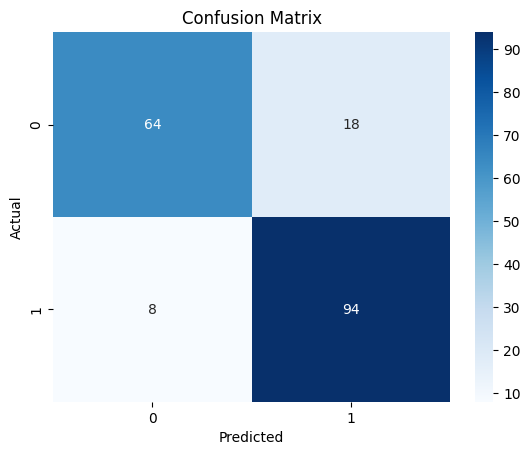

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert probabilities to class labels using threshold 0.5
xgb_class_preds = (xgb_preds >= 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, xgb_class_preds)

# Plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()


In [31]:
print(sensor_scaler.mean_.shape)  # Should output (11,)


(11,)


In [35]:
import joblib
import pickle 
with open("sensor_scaler3.pkl", "wb") as f:
    pickle.dump(sensor_scaler, f)
with open("mri_scaler2.pkl", "wb") as f:
    pickle.dump(mri_scaler, f)
with open("sensor_pca3.pkl", "wb") as f:
    pickle.dump(sensor_pca, f)
with open("mri_pca2.pkl", "wb") as f:
    pickle.dump(mri_pca, f)
joblib.dump(xgb_model, "xgb_model2.pkl")

# Save DNN model state_dict (use torch)
torch.save(dnn_model.state_dict(), "dnn_model_state_dict2.pth")

print("Models saved successfully!")


print("💾 All models and scalers saved successfully!")

Models saved successfully!
💾 All models and scalers saved successfully!


: 